In [ ]:
# https://supersoftware.jp/tech/20220907/17599/

In [1]:
import numpy as np
from sklearn.metrics import r2_score
from pandas_datareader import data as pdr
import yfinance as yf
yf.pdr_override()
from datetime import datetime
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout
import matplotlib.pyplot as plt
plt.style.use("fivethirtyeight")
%matplotlib inline

c:\Users\nakamura\anaconda3\lib\site-packages\scipy\__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.25.2
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
s_target = 'GOOG'
df = pdr.get_data_yahoo(s_target, start='2014-01-01', end=datetime.now())
df.head()

[*********************100%%**********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2014-01-02,27.782366,27.839401,27.603037,27.724083,27.724083,73129082
2014-01-03,27.770908,27.818977,27.520098,27.521841,27.521841,66917888
2014-01-06,27.721344,27.867046,27.557707,27.828691,27.828691,71037271
2014-01-07,28.019974,28.385853,27.924334,28.365179,28.365179,102486711
2014-01-08,28.543015,28.575891,28.226450,28.424210,28.424210,90036218


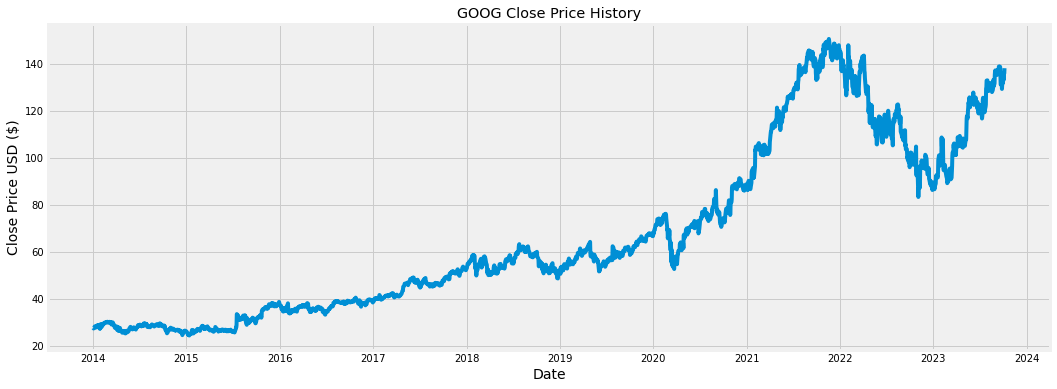

In [3]:
plt.figure(figsize=(16,6))
plt.title(s_target + ' Close Price History')
plt.plot(df['Close'])
plt.xlabel('Date', fontsize=14)
plt.ylabel('Close Price USD ($)', fontsize=14)
plt.show()

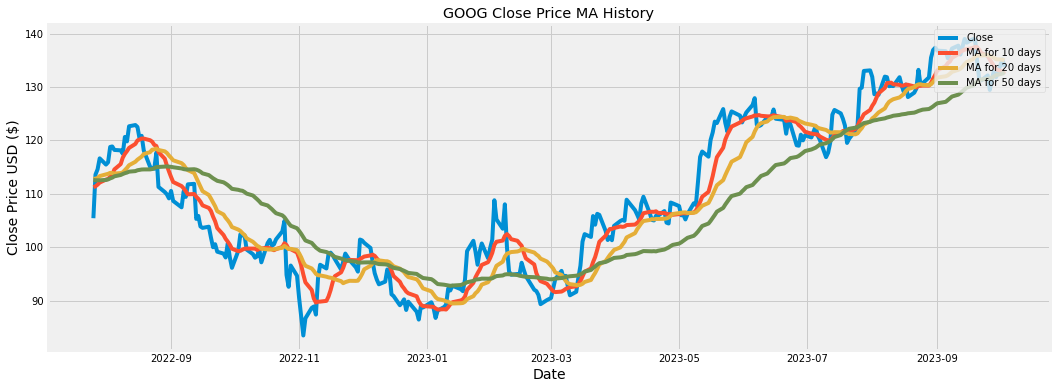

In [4]:
ma_day = [10, 20, 50]
for ma in ma_day:
    column_name = f"MA for {ma} days"
    df[column_name] = df['Adj Close'].rolling(ma).mean()

plt.figure(figsize=(16,6))
plt.title(s_target + ' Close Price MA History')
plt.plot(df['Close'][-300:])
plt.plot(df['MA for 10 days'][-300:])
plt.plot(df['MA for 20 days'][-300:])
plt.plot(df['MA for 50 days'][-300:])
plt.xlabel('Date', fontsize=14)
plt.ylabel('Close Price USD ($)', fontsize=14)
plt.legend(['Close', 'MA for 10 days', 'MA for 20 days', 'MA for 50 days'], loc='upper right')
plt.show()

In [5]:
# Close(終値)のデータ
data = df.filter(['Close'])
dataset = data.values

# データを0〜1の範囲に正規化
scaler = MinMaxScaler(feature_range=(0,1))
scaled_data = scaler.fit_transform(dataset)
scaled_data

array([[0.02508157],
       [0.02347837],
       [0.02591081],
       ...,
       [0.87682019],
       [0.86199648],
       [0.88169542]])

In [6]:
# 全体の80%をトレーニングデータとして扱う
training_data_len = int(np.ceil( len(dataset) * .8 ))

In [7]:
# どれくらいの期間をもとに予測するか
window_size = 60

train_data = scaled_data[0:int(training_data_len), :]

# train_dataをx_trainとy_trainに分ける
x_train, y_train = [], []
for i in range(window_size, len(train_data)):
    x_train.append(train_data[i-window_size:i, 0])
    y_train.append(train_data[i, 0])

# numpy arrayに変換
x_train, y_train = np.array(x_train), np.array(y_train)
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))

In [8]:
model = Sequential()
model.add(LSTM(units=50,return_sequences=True,input_shape=(x_train.shape[1], 1)))
model.add(Dropout(0.2))
model.add(LSTM(units=50,return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(units=50,return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(units=50))
model.add(Dropout(0.2))
model.add(Dense(units=1))

model.compile(optimizer='adam', loss='mean_squared_error')
history = model.fit(x_train, y_train, batch_size=32, epochs=100)

Epoch 1/100
60/60 [==============================] - 17s 124ms/step - loss: 0.0116
Epoch 2/100
60/60 [==============================] - 6s 105ms/step - loss: 0.0020
Epoch 3/100
60/60 [==============================] - 6s 107ms/step - loss: 0.0016
Epoch 4/100
60/60 [==============================] - 6s 106ms/step - loss: 0.0021
Epoch 5/100
60/60 [==============================] - 7s 110ms/step - loss: 0.0016
Epoch 6/100
60/60 [==============================] - 7s 108ms/step - loss: 0.0015
Epoch 7/100
60/60 [==============================] - 6s 107ms/step - loss: 0.0016
Epoch 8/100
60/60 [==============================] - 6s 106ms/step - loss: 0.0017
Epoch 9/100
60/60 [==============================] - 6s 104ms/step - loss: 0.0014
Epoch 10/100
60/60 [==============================] - 6s 104ms/step - loss: 0.0011
Epoch 11/100
60/60 [==============================] - 6s 103ms/step - loss: 0.0013
Epoch 12/100
60/60 [==============================] - 6s 104ms/step - loss: 0.0013
Epoch 13/100

In [9]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 60, 50)            10400     
                                                                 
 dropout (Dropout)           (None, 60, 50)            0         
                                                                 
 lstm_1 (LSTM)               (None, 60, 50)            20200     
                                                                 
 dropout_1 (Dropout)         (None, 60, 50)            0         
                                                                 
 lstm_2 (LSTM)               (None, 60, 50)            20200     
                                                                 
 dropout_2 (Dropout)         (None, 60, 50)            0         
                                                                 
 lstm_3 (LSTM)               (None, 50)                2

In [10]:
# テストデータを作成
test_data = scaled_data[training_data_len - window_size: , :]

x_test = []
y_test = dataset[training_data_len:, :]
for i in range(window_size, len(test_data)):
    x_test.append(test_data[i-window_size:i, 0])

# numpy arrayに変換
x_test = np.array(x_test)
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1 ))

In [11]:
# 予測を実行する
predictions = model.predict(x_test)
predictions = scaler.inverse_transform(predictions)

# 二乗平均平方根誤差（RMSE）: 0に近いほど良い
rmse = np.sqrt(np.mean(((predictions - y_test) ** 2)))
print(rmse)

# 決定係数(r2) : 1に近いほど良い
r2s = r2_score(y_test, predictions)
print(r2s)

16/16 [==============================] - 3s 38ms/step
4.674526223480875
0.9298429572446131


C:\Users\nakamura\AppData\Local\Temp/ipykernel_7908/3339233618.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid['Predictions'] = predictions


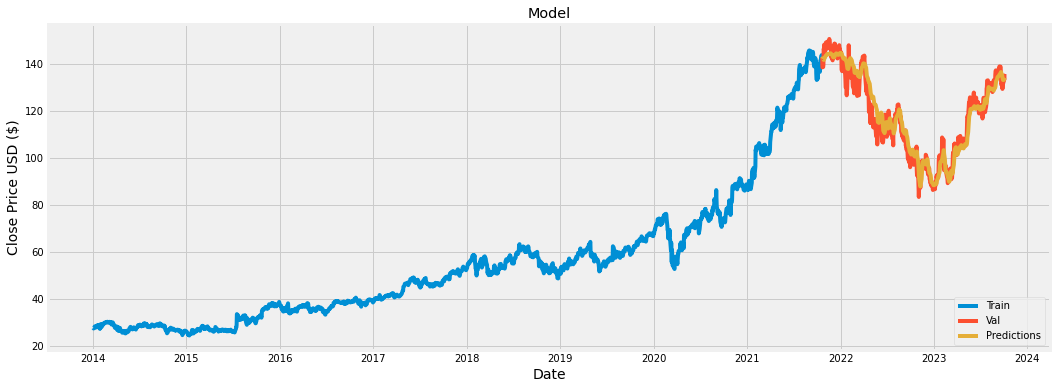

In [12]:
train = data[:training_data_len]
valid = data[training_data_len:]
valid['Predictions'] = predictions

plt.figure(figsize=(16,6))
plt.title('Model')
plt.xlabel('Date', fontsize=14)
plt.ylabel('Close Price USD ($)', fontsize=14)
plt.plot(train['Close'])
plt.plot(valid[['Close', 'Predictions']])
plt.legend(['Train', 'Val', 'Predictions'], loc='lower right')
plt.show()